# DATA LOAD

# COVID-19 Xray Dataset (Train & Test Sets)

This dataset is derived from the [SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR](https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/) repository, which transformed data originally sourced from the [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset).

## Background

The 2019 novel coronavirus (COVID-19) presents several unique features. While the diagnosis is confirmed using polymerase chain reaction (PCR), infected patients with pneumonia may present on chest X-ray and computed tomography (CT) images with a pattern that is only moderately characteristic for the human eye (Ng, 2020). The rate of transmission of COVID-19 depends on our ability to reliably identify infected patients with a low rate of false negatives. It is equally important to minimize false positives to avoid unnecessary burden on the healthcare system by subjecting patients to unnecessary quarantine measures. Timely detection of the disease is crucial for implementing appropriate supportive care for COVID-19 patients.

In late January, a Chinese team published a paper detailing the clinical and radiological features of COVID-19. They observed abnormalities in chest CT images, with most patients showing bilateral involvement and specific patterns of consolidation in intensive care unit (ICU) admissions (Huang, 2020). Non-ICU patients typically exhibit bilateral ground-glass opacity and consolidation in their chest CT images, which may evolve over time (Huang, 2020).

Radiological imaging, particularly chest CT scans, plays a significant role in the diagnosis of COVID-19, as highlighted by recent studies (Fang, 2020; Ai, 2020).

## Dataset Description

This dataset contains train and test sets derived from the above sources, curated to facilitate research and development of machine learning models for COVID-19 detection based on chest X-ray and CT scan images.

---

**Note:** For access to the dataset, please refer to the original repositories: [SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR](https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/) and [covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset).


In [2]:
import pandas as pd
train_dir = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train"
test_dir = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test"

In [3]:
import os
# Get the list of all files and subdirectories in the train_dir directory and store it in the classes_train variable
classes_train = os.listdir(train_dir)

# Get the list of all files and subdirectories in the test_dir directory and store it in the classes_test variable
classes_test = os.listdir(test_dir)

In [4]:
print(classes_train, classes_test)

['PNEUMONIA', 'NORMAL'] ['PNEUMONIA', 'NORMAL']


# Data Augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training data with augmentation options
train_datagen = ImageDataGenerator(
    zoom_range=0.2,               # Randomly zoom into images by 20%
    horizontal_flip=True,         # Randomly flip images horizontally
    rescale=1.0/255.0,            # Rescale pixel values from range [0, 255] to [0, 1]
    width_shift_range=0.10,       # Randomly shift images horizontally by 10% of width
    height_shift_range=0.10,      # Randomly shift images vertically by 10% of height
    shear_range=0.1               # Apply random shear transformations by 10%
)

# Create a data generator for training data using the train_datagen instance
train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Directory containing the training images
    class_mode='binary',          # Set the classification mode to binary (two categories)
    color_mode='rgb',             # Use RGB color mode for the images
    batch_size=32,                # Set the batch size for the data generator
    target_size=(1000, 1000, 3)[:2] # Set the target image size to 1000x1000 pixels
)

Found 148 images belonging to 2 classes.


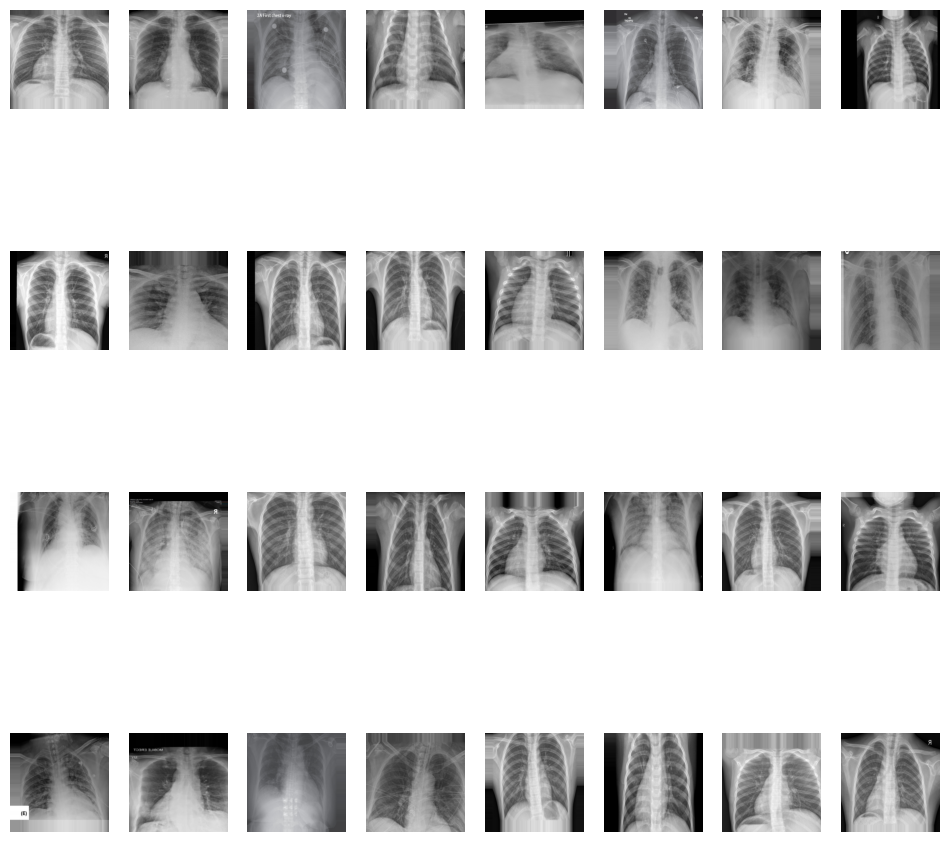

In [10]:
import matplotlib.pyplot as plt

# Generate a batch of augmented images
augmented_images, _ = next(train_generator)

# Display the augmented images
plt.figure(figsize=(12, 12))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [7]:
# For Testing Data
test_datagen=ImageDataGenerator(
    rescale=1.0/255.0
)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=32,
    target_size=(1000,1000,3)[:2]
)

Found 40 images belonging to 2 classes.


# Callbacks

In [8]:
# Import necessary callbacks from TensorFlow Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping callback to monitor validation accuracy and stop training if no improvement after 6 epochs
earlystop = EarlyStopping(patience=6)

# Define ReduceLROnPlateau callback to adjust learning rate when validation accuracy plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',    # Monitor validation accuracy
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,             # Print messages
    factor=0.5,            # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    min_lr=0.00001         # Lower bound on the learning rate
)


# MODELING

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout

# Define model
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(1000, 1000, 3)),
    MaxPooling2D((5, 5)),
    BatchNormalization(),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((5, 5)),
    BatchNormalization(),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D((5, 5)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile Model

In [55]:
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 996, 996, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 199, 199, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 195, 195, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 39, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 39, 39, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 35, 35, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,471,809 (13.24 MB)

 Trainable params: 3,471,361 (13.24 MB)

 Non-trainable params: 448 (1.75 KB)

In [57]:
callbacks = [earlystop, learning_rate_reduction]

# FIT

In [58]:
model.fit(
    train_generator, 
    epochs=20,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/20


W0000 00:00:1720968216.861286    1660 hlo_rematerialization.cc:2946] Can't reduce memory use below 10.84GiB (11638338834 bytes) by rematerialization; only reduced to 11.38GiB (12217675428 bytes), down from 11.74GiB (12601675428 bytes) originally
W0000 00:00:1720968219.472029    1660 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.5814 - loss: 3.6579

W0000 00:00:1720968225.463078    1660 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6043 - loss: 3.6660   

W0000 00:00:1720968228.976161    1661 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6196 - loss: 3.6714 - val_accuracy: 0.6000 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1720968229.559991    1659 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 887ms/step - accuracy: 0.8150 - loss: 1.7865 - val_accuracy: 0.5000 - val_loss: 1.8374 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 835ms/step - accuracy: 0.8770 - loss: 0.8007 - val_accuracy: 0.5000 - val_loss: 1.4693 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 839ms/step - accuracy: 0.9308 - loss: 0.2414 - val_accuracy: 0.8250 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 845ms/step - accuracy: 0.9587 - loss: 0.2067 - val_accuracy: 0.8000 - val_loss: 0.3757 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 845ms/step - accuracy: 0.9286 - loss: 0.3596 - val_accuracy: 0.9000 - val_loss: 0.2821 - learning_rate: 0.0010


# Accuracy

In [59]:
losses = pd.DataFrame(model.history.history)
losses.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
1,0.851351,1.204504,0.500,1.837354,0.001
2,0.864865,0.865121,0.500,1.469305,0.001
3,0.918919,0.315216,0.825,0.353040,0.001
4,0.952703,0.226645,0.800,0.375749,0.001
5,0.925676,0.531322,0.900,0.282089,0.001


<Axes: >

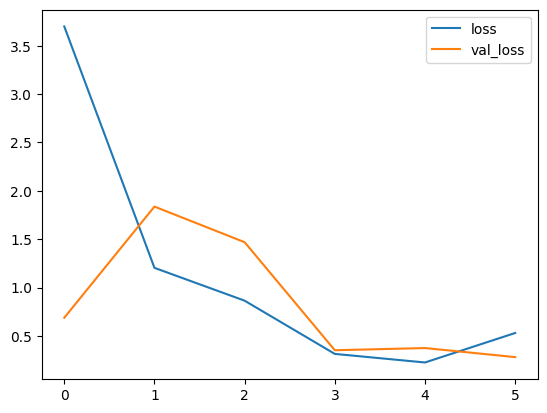

In [60]:
losses[['loss','val_loss']].plot()

<Axes: >

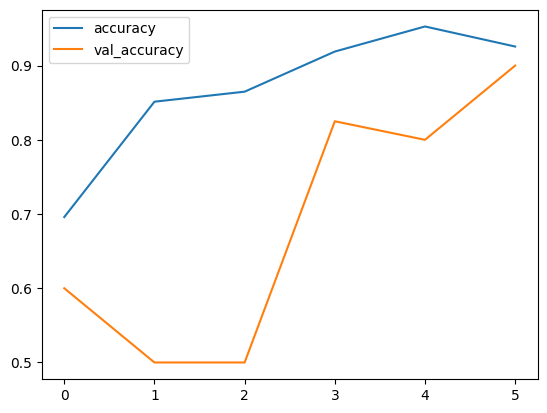

In [61]:
losses[['accuracy','val_accuracy']].plot()

<Axes: >

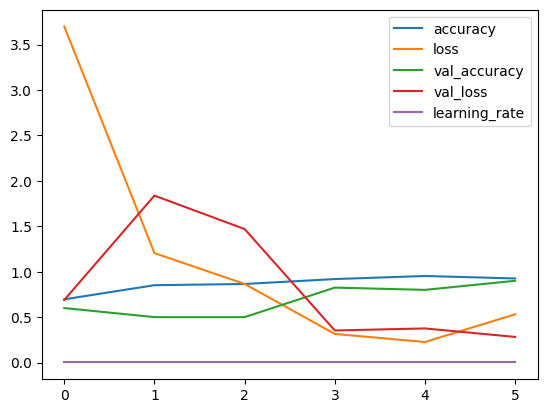

In [62]:
losses.plot()

In [63]:
model.evaluate(test_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9021 - loss: 0.2752


[0.2820890545845032, 0.8999999761581421]

# PREDICTIONS

In [64]:
model_pred=model.predict(test_generator)
print(model_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step
[[0.9175024 ]
 [0.94047266]
 [0.6923171 ]
 [0.14643312]
 [0.395496  ]
 [0.7032096 ]
 [0.88663775]
 [0.9592619 ]
 [0.4770279 ]
 [0.27240053]
 [0.9818903 ]
 [0.94501096]
 [0.3453736 ]
 [0.05792756]
 [0.13693506]
 [0.9819762 ]
 [0.67420423]
 [0.20369022]
 [0.9583639 ]
 [0.04802762]
 [0.40551004]
 [0.9916255 ]
 [0.32521704]
 [0.77948076]
 [0.36209172]
 [0.7794722 ]
 [0.19937287]
 [0.04016323]
 [0.93710774]
 [0.12406377]
 [0.8567728 ]
 [0.45717958]
 [0.4845989 ]
 [0.10737657]
 [0.2628593 ]
 [0.92034453]
 [0.37319678]
 [0.30944493]
 [0.05795678]
 [0.801953  ]]


In [65]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# CHECK THE MODEL

In [66]:
class_names=['NORMAL','PNEUMONIA']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


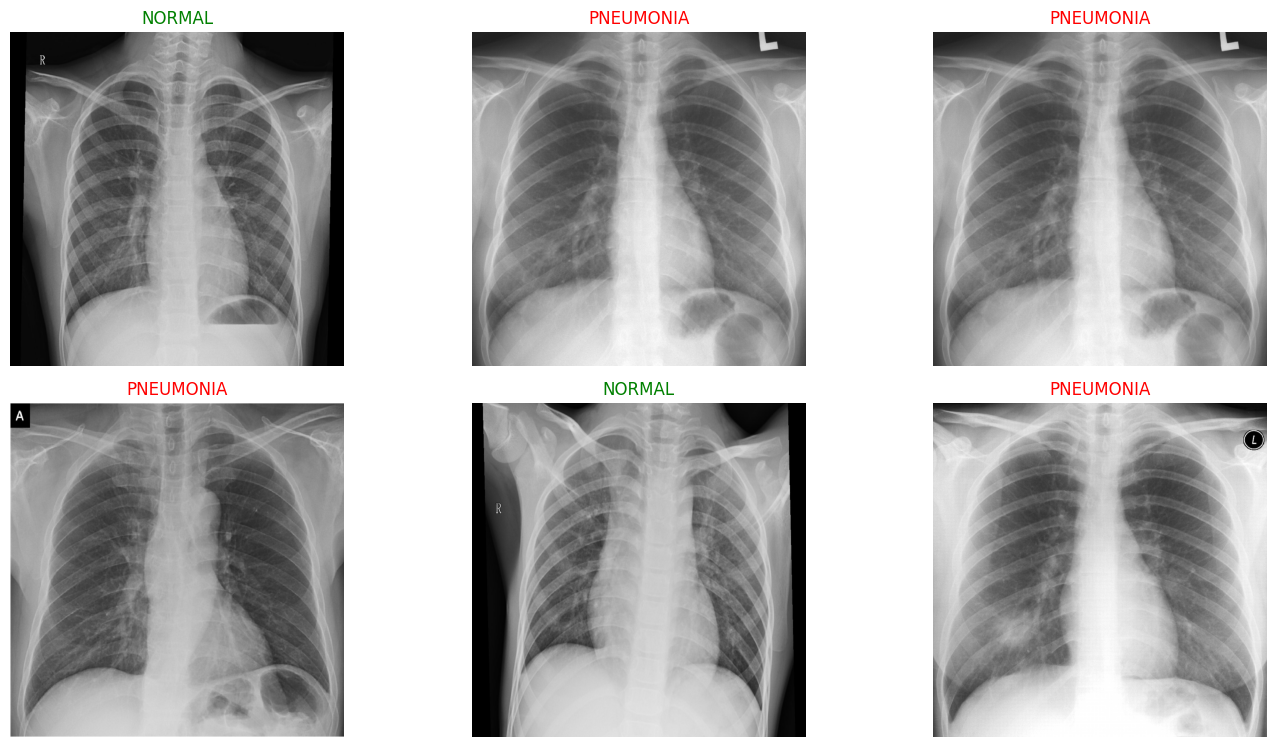

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_prediction(test_generator, n_images):
    """
    Test the model on random predictions
    Args:
    test_generator: a generator instance
    n_images : number of images to plot
    """
    plt.figure(figsize=(14, 15))
    for i in range(n_images):
        images, labels = next(test_generator)
        predictions = np.argmax(model.predict(images), axis=1)
        labels = labels.astype('int32')
        
        for image, prediction, label in zip(images, predictions, labels):
            plt.subplot(4, 3, i + 1)
            plt.imshow(image)
            
            if prediction == label:
                plt.title(class_names[label], color='g')
            else:
                plt.title(class_names[label], color='r')
                
            plt.axis('off')

    plt.tight_layout()
    plt.show()


plot_prediction(test_generator, 6)


The green color means the person was not sick and model predict it not sick so this correct

the red color means model predict it wrong

